In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

In [5]:
# =========【Configuration and parameters】=========
DATA_FOLDER = "/content/drive/MyDrive/Random/Hiroshima/ABC2025/Test"

# 训练 ID
USER_IDS = ["T1N01", "T1F01", "T1S01", "T1S02"]  # 这里替换成你需要训练的ID
# 测试 ID
TEST_IDS = ["T1N02", "T1F02"]  # 这里替换成你需要测试的ID

FS = 33  # Sampling rate

# Action label encoding mapping
action_mapping = {
    "Explanation to patient": 0,
    "Confirm necessary items": 1,
    "Disinfect hands": 2,
    "Wearing gloves": 3,
    "Prepare the nutrition solution": 4,
    "Check the gastrostomy site": 5,
    "Open the gastrostomy cap": 6,
    "Inject lukewarm water": 7,
    "Connect the nutrition tube": 8,
    "Adjust the infusion rate": 9,
    "Removal of gloves": 10,
    "Prepare lukewarm water": 11,
    "Close the clamp": 12,
    "Disconnect the nutrition tube": 13,
    "Close the gastrostomy cap": 14,
    "Clean up used items": 15,
    "Others": 16
}

# =========【Load and clean data】=========
def load_data(user_ids, data_folder=DATA_FOLDER, fs=FS):
    all_kp_data = []
    all_ann_data = []

    for user_id in user_ids:
        keypoint_csv = f"{data_folder}/Body_KeyPoint_CSV/Front_{user_id}.csv"
        ann_csv = f"{data_folder}/Annotation_CSV/Front_{user_id}.csv"

        # 读取并去掉多余列（如Unnamed等）
        kp_df_raw = pd.read_csv(keypoint_csv)
        ann_df_raw = pd.read_csv(ann_csv)
        kp_df = kp_df_raw.loc[:, ~kp_df_raw.columns.str.contains('^Unnamed')]
        ann_df = ann_df_raw.loc[:, ~ann_df_raw.columns.str.contains('^Unnamed')]

        # 根据需要清理一些不需要的关节点，如膝盖、脚踝等
        kp_df = kp_df.loc[:, ~kp_df.columns.str.contains('Frame|conf|left_knee|right_knee|left_ankle|right_ankle', regex=True)]

        all_kp_data.append(kp_df)
        all_ann_data.append(ann_df)
    return all_kp_data, all_ann_data

print("Loading training data...")
all_kp_data, all_ann_data = load_data(USER_IDS)
print("Loading testing data...")
test_all_kp_data, test_all_ann_data = load_data(TEST_IDS)
print("Data loaded successfully!")

Loading training data...
Loading testing data...
Data loaded successfully!


In [6]:
SMOOTH_LEN = 3  # Smoothing length, in seconds

def smooth_kp(kp_col, fs=FS, smooth_len=SMOOTH_LEN):
    zero_idx = np.flatnonzero(kp_col == 0)
    # 将连续的0分段
    split_idx = np.split(zero_idx, np.flatnonzero(np.diff(zero_idx) > 1) + 1)
    for each_split_idx in split_idx:
        # 如果是开头或结尾或长度过长，则跳过
        if len(each_split_idx) == 0 or each_split_idx[0] == 0 or each_split_idx[-1] == (len(kp_col) - 1) or len(each_split_idx) > smooth_len * fs:
            continue
        # 插值
        xp = [each_split_idx[0] - 1, each_split_idx[-1] + 1]
        fp = kp_col[xp]
        interp_kp = np.interp(each_split_idx, xp, fp)
        kp_col[each_split_idx] = interp_kp
    return kp_col

def smooth_all_data(all_kp_data):
    for kp_df in all_kp_data:
        for col in kp_df.columns:
            kp_df[col] = smooth_kp(np.array(kp_df[col]))
    return all_kp_data

print("Smoothing training data...")
all_kp_data = smooth_all_data(all_kp_data)
print("Smoothing testing data...")
test_all_kp_data = smooth_all_data(test_all_kp_data)
print("All data smoothed!")


Smoothing training data...
Smoothing testing data...
All data smoothed!


In [7]:
# 将 annotation 的中文或英文行为类别映射成数字 ID
for ann_df in all_ann_data:
    ann_df["activityID"] = ann_df["annotation"].map(action_mapping)

for test_ann_df in test_all_ann_data:
    test_ann_df["activityID"] = test_ann_df["annotation"].map(action_mapping)

print("Mapped activity labels to activity IDs.")

Mapped activity labels to activity IDs.


In [8]:
WINDOW_SIZE = 2  # seconds
OVERLAP_RATE = 0.5 * WINDOW_SIZE  # overlap in seconds

def segment(data, max_time, sub_window_size, stride_size):
    """
    将 data 切分成长度为 sub_window_size 的窗口，每个窗口移动 stride_size。
    data: numpy array, shape = (n_frames, n_features)
    """
    sub_windows = np.arange(sub_window_size)[None, :] + np.arange(0, max_time, stride_size)[:, None]
    # 找到超过边界的窗口所在行
    row, _ = np.where(sub_windows >= max_time)
    uniq_row = len(np.unique(row))
    # 去掉超过边界的多余窗口
    if uniq_row > 0 and row[0] > 0:
        sub_windows = sub_windows[:-uniq_row, :]
    return data[sub_windows]

In [27]:
def cal_angle(a, b, c):
    """
    计算由三点 a, b, c 构成的夹角 (b为中心)
    a, b, c: (x, y) or (x, y, z)
    """
    ba= a - b
    bc= c - b
    norm_ba= np.linalg.norm(ba)
    norm_bc= np.linalg.norm(bc)
    if norm_ba<1e-12 or norm_bc<1e-12:
        return 0
    cos_val= np.dot(ba, bc)/(norm_ba*norm_bc)
    if cos_val>1.0:
        cos_val=1.0
    elif cos_val< -1.0:
        cos_val= -1.0
    return np.arccos(cos_val)

def extract_joint_angles(kp_data, steps=2):
    """
    计算6个关节角度，返回 shape: (n_frames, 6)

      1) left_elbow_shoulder_hip
      2) right_elbow_shoulder_hip
      3) left_wrist_elbow_shoulder
      4) right_wrist_elbow_shoulder
      5) right_elbow_shoulder
      6) left_elbow_shoulder

      steps=2 => (x,y)； steps=3 => (x,y,conf)
      kp_data shape: (n_frames, n_features)
    """

    # 1) left_elbow_shoulder_hip
    left_elbow_shoulder_hip= np.asarray([
        cal_angle(
            kp_data[i, 7*steps:(7*steps+2)],  # left_elbow
            kp_data[i, 5*steps:(5*steps+2)],  # left_shoulder
            kp_data[i, 11*steps:(11*steps+2)] # left_hip
        )
        for i in range(len(kp_data))
    ], dtype=np.float32)
    left_elbow_shoulder_hip= np.nan_to_num(left_elbow_shoulder_hip)

    # 2) right_elbow_shoulder_hip
    right_elbow_shoulder_hip= np.asarray([
        cal_angle(
            kp_data[i, 8*steps:(8*steps+2)],  # right_elbow
            kp_data[i, 6*steps:(6*steps+2)],  # right_shoulder
            kp_data[i, 12*steps:(12*steps+2)] # right_hip
        )
        for i in range(len(kp_data))
    ], dtype=np.float32)
    right_elbow_shoulder_hip= np.nan_to_num(right_elbow_shoulder_hip)

    # 3) left_wrist_elbow_shoulder
    left_wrist_elbow_shoulder= np.asarray([
        cal_angle(
            kp_data[i, 9*steps:(9*steps+2)],  # left_wrist
            kp_data[i, 7*steps:(7*steps+2)],  # left_elbow
            kp_data[i, 5*steps:(5*steps+2)]   # left_shoulder
        )
        for i in range(len(kp_data))
    ], dtype=np.float32)
    left_wrist_elbow_shoulder= np.nan_to_num(left_wrist_elbow_shoulder)

    # 4) right_wrist_elbow_shoulder
    right_wrist_elbow_shoulder= np.asarray([
        cal_angle(
            kp_data[i, 10*steps:(10*steps+2)], # right_wrist
            kp_data[i, 8*steps:(8*steps+2)],   # right_elbow
            kp_data[i, 6*steps:(6*steps+2)]    # right_shoulder
        )
        for i in range(len(kp_data))
    ], dtype=np.float32)
    right_wrist_elbow_shoulder= np.nan_to_num(right_wrist_elbow_shoulder)

    # 5) right_elbow_shoulder
    right_elbow_shoulder= np.asarray([
        cal_angle(
            kp_data[i, 8*steps:(8*steps+2)],  # right_elbow
            kp_data[i, 6*steps:(6*steps+2)],  # right_shoulder
            kp_data[i, 5*steps:(5*steps+2)]   # left_shoulder? or right_shoulder? (自行检查)
        )
        for i in range(len(kp_data))
    ], dtype=np.float32)
    right_elbow_shoulder= np.nan_to_num(right_elbow_shoulder)

    # 6) left_elbow_shoulder
    left_elbow_shoulder= np.asarray([
        cal_angle(
            kp_data[i, 6*steps:(6*steps+2)],  # left_shoulder
            kp_data[i, 5*steps:(5*steps+2)],  # right_shoulder? (注意具体想计算啥)
            kp_data[i, 7*steps:(7*steps+2)]   # left_elbow
        )
        for i in range(len(kp_data))
    ], dtype=np.float32)
    left_elbow_shoulder= np.nan_to_num(left_elbow_shoulder)

    # 组合
    joint_angles= np.column_stack([
        left_elbow_shoulder_hip,
        right_elbow_shoulder_hip,
        left_wrist_elbow_shoulder,
        right_wrist_elbow_shoulder,
        right_elbow_shoulder,
        left_elbow_shoulder
    ])
    return joint_angles  # shape: (n_frames, 6)

In [28]:
def extract_velocity(kp_data):
    return np.diff(kp_data, axis=0)

def extract_acceleration(kp_data):
    vel= extract_velocity(kp_data)
    acc= np.diff(vel, axis=0)
    return np.linalg.norm(acc, axis=1)

def extract_jerk(kp_data):
    vel= extract_velocity(kp_data)
    acc= np.diff(vel, axis=0)
    jerk= np.diff(acc, axis=0)
    return np.linalg.norm(jerk, axis=1)

def extract_feature_1D(data):
    if len(data)==0:
        return np.zeros(6, dtype=np.float32)
    return np.array([
        data.mean(),
        data.std(),
        data.max(),
        data.min(),
        np.median(data),
        data.sum()
    ], dtype=np.float32)

def extract_joint_distance_ratios(kp_data):
    if kp_data.shape[1]<22:
        return np.array([])
    ls= kp_data[:, [12,13]]
    le= kp_data[:, [16,17]]
    lw= kp_data[:, [20,21]]
    dist1= np.linalg.norm(le-ls, axis=1)
    dist2= np.linalg.norm(lw-ls, axis=1)
    eps=1e-9
    return dist1/(dist2+eps)

def extract_joint_pair_angle_rates(kp_data):
    def cal_angle(a,b,c):
        ba= a-b
        bc= c-b
        nb= np.linalg.norm(ba)
        nc= np.linalg.norm(bc)
        if nb<1e-12 or nc<1e-12:
            return 0
        cosv= np.dot(ba, bc)/(nb*nc)
        cosv= min(1.0, max(-1.0, cosv))
        return np.arccos(cosv)
    if kp_data.shape[1]<26:
        return np.array([])
    ls= kp_data[:, [12,13]]
    le= kp_data[:, [16,17]]
    lh= kp_data[:, [24,25]]
    angles=[]
    for i in range(len(kp_data)):
        angles.append(cal_angle(le[i], ls[i], lh[i]))
    angles= np.array(angles)
    angle_rates= np.diff(angles)
    return angle_rates

def extract_feature(data, fs):
    # 做 7 种统计
    mean_ft= np.mean(data, axis=0)
    std_ft = np.std(data, axis=0)
    max_ft = np.max(data, axis=0)
    min_ft = np.min(data, axis=0)
    var_ft = np.var(data, axis=0)
    med_ft = np.median(data, axis=0)
    sum_ft = np.sum(data, axis=0)
    feats  = np.array([mean_ft, std_ft, max_ft, min_ft, var_ft, med_ft, sum_ft]).T.flatten()
    feats  = np.nan_to_num(feats)
    return feats

def extract_baseline_features(sub_seg):
    # baseline = extract_feature(sub_seg) + 1 scalar angle
    feats_base_1= extract_feature(sub_seg, fs=FS)
    angle_val=0
    if len(sub_seg)>0 and sub_seg.shape[1]>=6:
        row0= sub_seg[0,:]
        a= row0[0:2]
        b= row0[2:4]
        c= row0[4:6]
        angle_val= cal_angle(a,b,c)
    feats_base_2= np.array([angle_val], dtype=np.float32)
    baseline_feats= np.concatenate([feats_base_1, feats_base_2])
    return baseline_feats

# ==========【主函数：extract_all_features】==========
def extract_all_features(kp_df, ann_df):
    all_features= []
    all_labels  = []

    for i in range(len(ann_df)):
        start_idx= int(ann_df['start_time'].iloc[i]*FS)
        stop_idx = int(ann_df['stop_time'].iloc[i]*FS)
        seg= kp_df.loc[start_idx:stop_idx]
        seg_label= ann_df["activityID"].iloc[i]

        if len(seg)< WINDOW_SIZE*FS:
            continue

        # 分段
        ws_seg= segment(np.array(seg), max_time=len(seg),
                        sub_window_size=WINDOW_SIZE*FS,
                        stride_size=int((WINDOW_SIZE-OVERLAP_RATE)*FS))
        for sub_seg in ws_seg:
            # ==========【1) Baseline】==========
            feats_baseline= extract_baseline_features(sub_seg)

            # ==========【2) Acc】==========
            acc= extract_acceleration(sub_seg)
            feats_acc= extract_feature_1D(acc)

            # ==========【3) Jerk】==========
            jerk= extract_jerk(sub_seg)
            feats_jerk= extract_feature_1D(jerk)

            # ==========【4) Joint Dist Ratios】==========
            ratio_arr= extract_joint_distance_ratios(sub_seg)
            feats_ratio= extract_feature_1D(ratio_arr)

            # ==========【5) Joint Pair Angle Rates】==========
            angle_arr= extract_joint_pair_angle_rates(sub_seg)
            feats_angle= extract_feature_1D(angle_arr)

            # ==========【6) Joint Angles (6维)】==========
            # 这里演示 steps=2
            joint_angles= extract_joint_angles(sub_seg, steps=2)
            # shape: (window_frames, 6)
            # 如果要做统计 (例如 mean, std...):
            # flatten or do 1D stats:
            mean_angles= np.mean(joint_angles, axis=0)   # shape(6,)
            std_angles = np.std(joint_angles, axis=0)    # shape(6,)
            # 合并 => shape(12,)
            feats_joint_angles= np.concatenate([mean_angles, std_angles])

            # 最终合并 => baseline + acc(6) + jerk(6) + ratio(6) + angleRates(6) + jointAnglesStats(12)
            combined= np.concatenate([
                feats_baseline, feats_acc, feats_jerk, feats_ratio, feats_angle, feats_joint_angles
            ])
            all_features.append(combined)
            all_labels.append(seg_label)

    if len(all_features)==0:
        return np.array([]), np.array([])
    all_features= np.array(all_features, dtype=np.float32)
    all_labels  = np.array(all_labels,   dtype=np.int32)
    return all_features, all_labels

print("Extracting features for training data...")
train_all_features, train_all_labels= [], []
for kp_df, ann_df in zip(all_kp_data, all_ann_data):
    feats, labs= extract_all_features(kp_df, ann_df)
    if len(feats)>0:
        train_all_features.append(feats)
        train_all_labels.append(labs)

if len(train_all_features)>0:
    train_all_features= np.vstack(train_all_features)
    train_all_labels  = np.hstack(train_all_labels)
else:
    train_all_features= np.array([])
    train_all_labels  = np.array([])

print("Extracting features for testing data...")
test_all_features, test_all_labels= [], []
for kp_df, ann_df in zip(test_all_kp_data, test_all_ann_data):
    feats, labs= extract_all_features(kp_df, ann_df)
    if len(feats)>0:
        test_all_features.append(feats)
        test_all_labels.append(labs)

if len(test_all_features)>0:
    test_all_features= np.vstack(test_all_features)
    test_all_labels  = np.hstack(test_all_labels)
else:
    test_all_features= np.array([])
    test_all_labels  = np.array([])

print("Train feature shape:", train_all_features.shape)
print("Test  feature shape:", test_all_features.shape)

Extracting features for training data...
Extracting features for testing data...
Train feature shape: (1069, 219)
Test  feature shape: (526, 219)


In [29]:
# 检查训练/测试数据中是否有 NaN 或 Inf
print("NaN in training features:", np.isnan(train_all_features).sum())
print("NaN in testing features:", np.isnan(test_all_features).sum())
print("Inf in training features:", np.isinf(train_all_features).sum())
print("Inf in testing features:", np.isinf(test_all_features).sum())

# 将 NaN/Inf 替换为 0
train_all_features = np.nan_to_num(train_all_features, nan=0.0, posinf=0.0, neginf=0.0)
test_all_features = np.nan_to_num(test_all_features, nan=0.0, posinf=0.0, neginf=0.0)

NaN in training features: 54
NaN in testing features: 0
Inf in training features: 0
Inf in testing features: 0


In [30]:
# ==========【数据平衡：SMOTE】==========
!pip install imbalanced-learn --quiet
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(train_all_features, train_all_labels)

# ==========【训练模型 (RandomForest)】==========
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    n_jobs=-1,
    random_state=42
)

model_rf.fit(X_train_resampled, y_train_resampled)
print("Model training completed!")


Model training completed!


Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.41      0.44        51
           1       0.84      0.60      0.70        35
           2       0.24      0.47      0.32        17
           3       0.93      0.41      0.57        63
           4       0.47      0.78      0.58        18
           5       0.38      0.52      0.44        21
           6       0.00      0.00      0.00         9
           7       0.65      0.88      0.75        89
           8       0.41      0.23      0.30        30
           9       0.97      0.97      0.97        34
          10       0.14      0.10      0.12        10
          11       0.50      0.83      0.62        12
          12       0.00      0.00      0.00         4
          13       0.29      0.41      0.34        17
          14       0.00      0.00      0.00        10
          15       0.32      0.37      0.34        19
          16       0.40      0.36      0.38        87

   

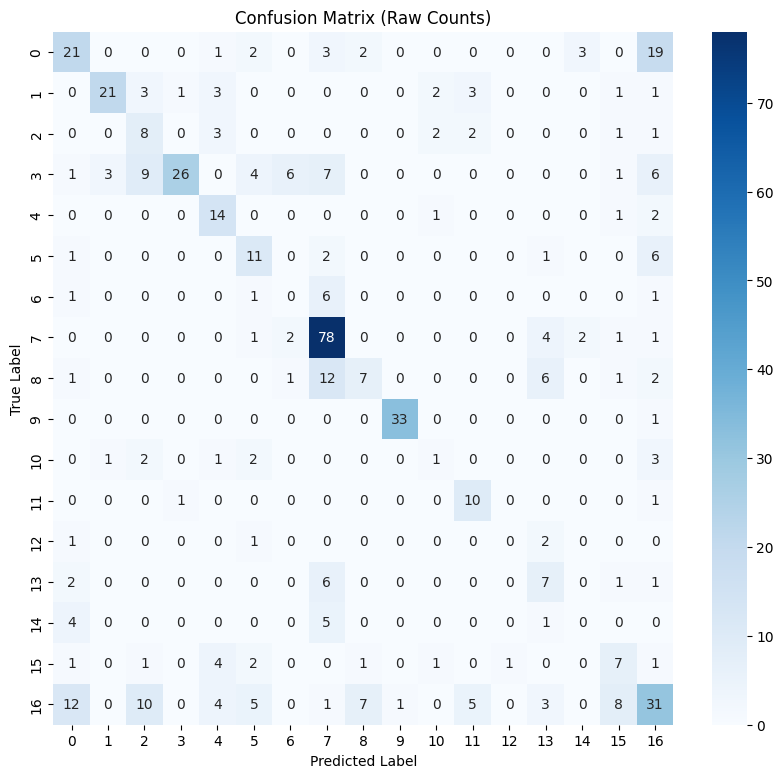

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 预测
y_pred = model_rf.predict(test_all_features)

# 分类报告
print("Classification Report:")
print(classification_report(test_all_labels, y_pred))

# 计算混淆矩阵（原始计数）
cm = confusion_matrix(test_all_labels, y_pred, labels=np.unique(test_all_labels))

plt.figure(figsize=(10, 9))

# 在 heatmap 中使用 cm (未归一化)，并将 fmt 设置成 'd' 显示整型
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            yticklabels=np.unique(test_all_labels),
            xticklabels=np.unique(test_all_labels))
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
